In [9]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [10]:
def smart_scraper_func(openai_key: str, prompt: str, source: str):
    """
    Performs intelligent scraping using SmartScraperGraph.

    Parameters:
    openai_key (str): The OpenAI API key.
    prompt (str): The prompt to use for scraping.
    source (str): The source from which to perform scraping.

    Returns:
    dict: The result of the scraping in JSON format.

    Example:
    >>> result = smart_scraper_func('your_openai_key', 'Extract article titles', 'https://example.com')
    >>> print(result)
    """
    import json
    from scrapegraphai.graphs import SmartScraperGraph

    graph_config = {
        "llm": {
            "api_key": os.getenv("OPENAI_API_KEY"),
            "model": "openai/gpt-4o",
        },
        "verbose": True,
    }

    smart_scraper_graph = SmartScraperGraph(
        prompt=prompt,
        source=source,
        config=graph_config
    )

    result = smart_scraper_graph.run()
    print(json.dumps(result, indent=4))

    return result


In [11]:
def search_graph_func(key: str, query: str):
    """
    Performs a search using SearchGraph.

    Parameters:
    key (str): The OpenAI API key.
    query (str): The search query to use.

    Returns:
    dict: The result of the search.

    Example:
    >>> result = search_graph_func('your_openai_key', 'example search')
    >>> print(result)
    """
    from scrapegraphai.graphs import SearchGraph

    graph_config = {
        "llm": {
            "api_key": os.getenv("OPENAI_API_KEY"),
            "model": "openai/gpt-4o",
        },
        "max_results": 2,
        "verbose": True,
    }

    search_graph = SearchGraph(
        prompt=query,
        config=graph_config
    )

    result = search_graph.run()
    print(result)

    return result


In [12]:
from langchain_openai import ChatOpenAI

tools = [smart_scraper_func, search_graph_func]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [13]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing scraping scripts with scrapegraphai")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

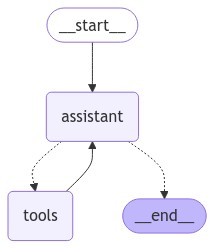

In [14]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
messages = [HumanMessage(content="Find me all the articles of https://www.wired.com using scrapegraph")]
messages = react_graph.invoke({"messages": messages})

--- Executing Fetch Node ---
--- (Fetching HTML from: https://www.wired.com) ---
--- Executing ParseNode Node ---
--- Executing GenerateAnswer Node ---


{
    "articles": [
        {
            "title": "From Dancing Trump to Fake Swifties, AI Is Infiltrating Elections Around the World",
            "link": "/story/generative-ai-global-elections/"
        },
        {
            "title": "License Plate Readers Are Creating a US-Wide Database of More Than Just Cars",
            "link": "/story/license-plate-readers-political-signs-bumper-stickers/"
        },
        {
            "title": "Inside the Anti-Vax Facebook Group Pushing a Bogus Cure for Autism",
            "link": "/story/inside-the-antivax-facebook-group-pushing-a-bogus-cure-for-autism/"
        },
        {
            "title": "The Meteoric Rise of Temu and Pinduoduo\u2014and What Might Finally Slow Them Down",
            "link": "/story/temu-pinduoduo-retail-us-china-imports-crackdown/"
        },
        {
            "title": "The 40 Best Shows on Max (aka HBO Max) Right Now",
            "link": "/story/hbo-max-best-shows-to-stream-right-now/"
        },
       

In [16]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find me all the articles of https://www.wired.com using scrapegraph
================================== Ai Message ==================================
Tool Calls:
  smart_scraper_func (call_Ff3WxmQ1g8n0iSVJspLkl8O0)
 Call ID: call_Ff3WxmQ1g8n0iSVJspLkl8O0
  Args:
    openai_key: your_openai_api_key
    prompt: Extract all article titles and links from Wired's website.
    source: https://www.wired.com
================================= Tool Message =================================
Name: smart_scraper_func

{"articles": [{"title": "From Dancing Trump to Fake Swifties, AI Is Infiltrating Elections Around the World", "link": "/story/generative-ai-global-elections/"}, {"title": "License Plate Readers Are Creating a US-Wide Database of More Than Just Cars", "link": "/story/license-plate-readers-political-signs-bumper-stickers/"}, {"title": "Inside the Anti-Vax Facebook Group Pushing a Bogus Cure for Autism", "li